In [1]:
# import required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


**Disclaimer**

**The Dataset and its description are from “Soft Sensors for monitoring
and Control of industrial Processes” Book**

**Link: [Soft Sensors for Monitoring and Control of Industrial Processes](https://link.springer.com/book/10.1007/978-1-84628-480-9)**

**PLS and SVR code from “Machine Learning in Python for Process Systems
Engineering” Book**

**Great Book By the way!** <br>

**Link to code:**

1.  **Link to PLS Code: [debutanizer_Softsensing_PLS](https://github.com/ML-PSE/Machine_Learning_for_PSE/blob/master/Chapter_ANN/debutanizer_PLS.ipynb)**

2.  **Link to SVR Code: [debutanizer_Softsensing_SVR](https://github.com/ML-PSE/Machine_Learning_for_PSE/blob/master/Chapter_SupportVectorMachines/debutanizer_Softsensing_SVR.ipynb)**

3.  **Link to FFNN Code: [debutanizer_FFNN](https://github.com/ML-PSE/Machine_Learning_for_PSE/blob/master/Chapter_ANN/debutanizer_FFNN.ipynb)**

**Link to Book: [Machine Learning in Python for Process Systems Engineering](https://leanpub.com/machineLearningPSE)** <br>

![Example Image](imgs/C4plant.png) <br>
The Debutanizer Column is part of a desulfuring and naphtha splitter
plant, shown above, where two gray circles, A1 and A2, can be
recognized. They represent the location of two gas chromatographs whose
data were used to design soft sensors, while the two white circles, N1
and N2, indicate the points where soft sensors were required.

In particular, data acquired by the device A2, i.e., the C4 (butane)
content in the bottom flow to stock have been used as a study case for
the design of the soft sensor named N2.

The debutanizer column C3 (propane) and C4 (butane) are removed as
overheads from the naphtha stream.

The debutanizer column is required to:

-   Ensure sufficient fractionation in the debutanizer;

-   maximize the C5 (Stabilized gasoline) content in the debutanizer
    overheads (LP gas splitter feed), while respecting the limit
    enforced by law;

-   minimize the C4 (butane) content in the debutanizer bottoms (Naphtha
    splitter feed)

A detailed Scheme of the debutanizer is show below where a number of
sensors, indicated with circles, are installed on the plant to monitor
product quality. The subset of sensors relevant to the application
described, indicated with gray circles, is listed below together with
the corresponding description.

| Variable | Description          |
|----------|----------------------|
| U1       | Top temperature      |
| U2       | Top pressure         |
| U3       | Reflux Flow          |
| U4       | Flow to next process |
| U5       | 6th temperature   |
| U6       | Bottom temperature   |
| U7       | Bottom temperature   |

![Example Image](imgs/C4column.png) <br>
The C4 Content in the debutanizer bottoms, i.e, the soft sensor output,
is measured on the overheads of the deisopentanizer column, as can be
observed in first figure, where the location of the measuring device is
indicated by the gray circle named A2. It measures the C4 Content in the
flow to stock that can all assumed to be coming out of the debutanizer
bottoms.

In [2]:
# read data
data = np.loadtxt('debutanizer_data.txt', skiprows=5)

In [3]:
column_names = {i:j for i,j in enumerate(['top Temperature','top Pressure','reflux flow','flow to next process','6th tray Temperature', 'bottom Temperature 1','bottom Temperature 2'
                                          ,'C4 content'])}
data_df = pd.DataFrame(data).rename(columns=column_names )
data_df.describe()

,top Temperature,top Pressure,reflux flow,flow to next process,6th tray Temperature,bottom Temperature 1,bottom Temperature 2,C4 content
count,2394.000000,2394.000000,2394.000000,2394.000000,2394.000000,2394.000000,2394.000000,2394.000000
mean,0.283894,0.667847,0.598467,0.435948,0.658086,0.620741,0.589397,0.267788
std,0.103143,0.057690,0.198581,0.138237,0.127054,0.165116,0.173251,0.158943
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.224004,0.653819,0.500390,0.363369,0.608661,0.481804,0.445001,0.169188
50%,0.263995,0.671915,0.624269,0.396288,0.694644,0.639585,0.600959,0.246857
75%,0.325607,0.690943,0.742784,0.518144,0.730119,0.755050,0.741387,0.318061
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


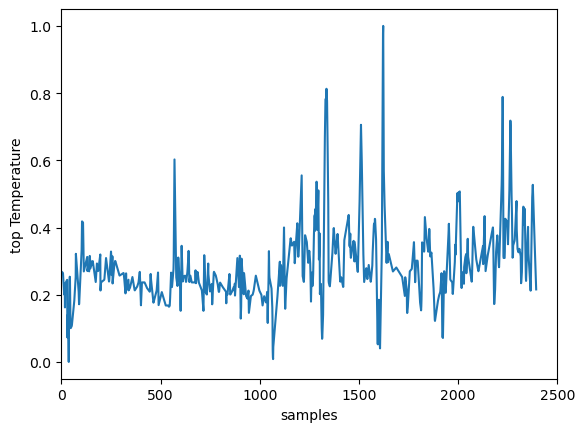

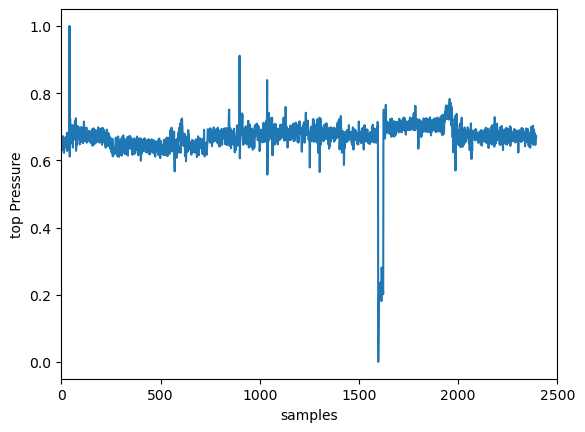

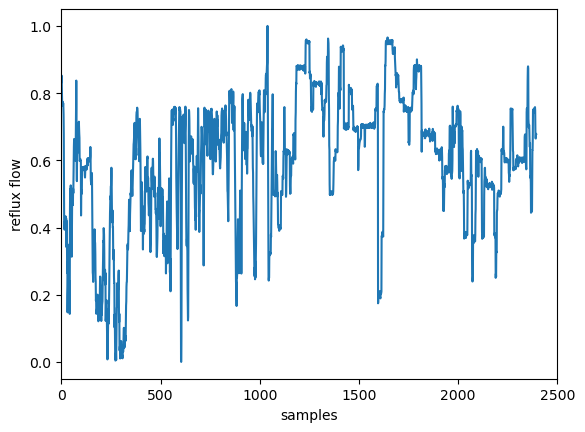

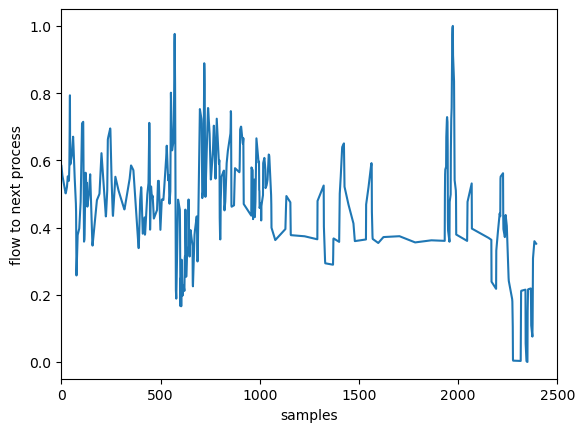

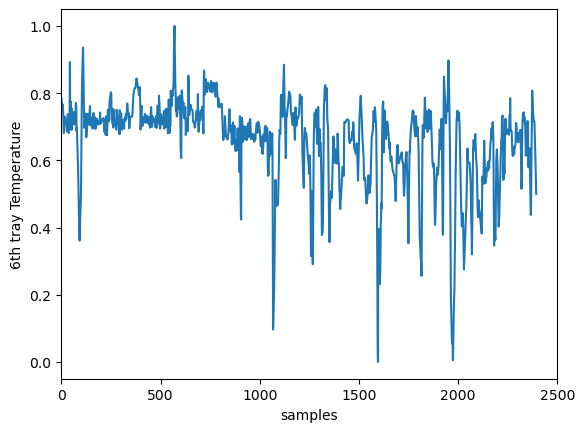

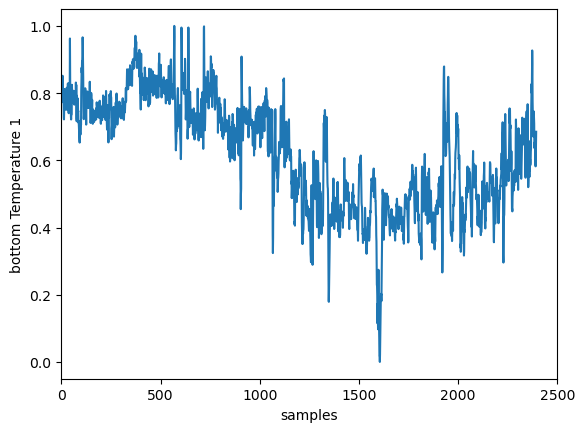

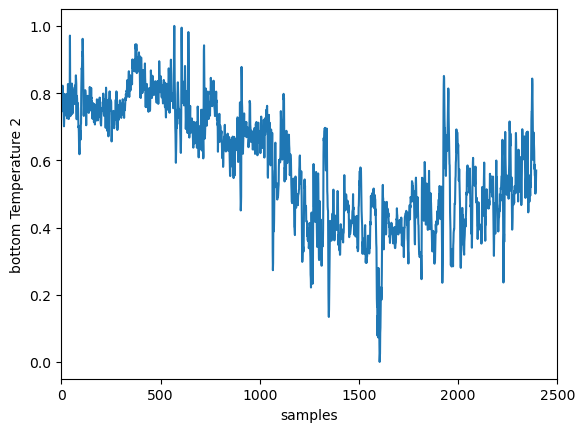

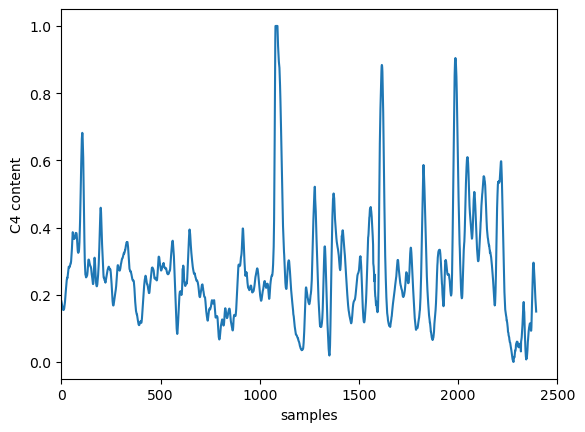

In [4]:
for i in range(8):
    plt.figure()
    plt.plot(data[:,i])
    plt.ylabel(column_names[i])
    plt.xlabel('samples')
    plt.xlim((0,2500))


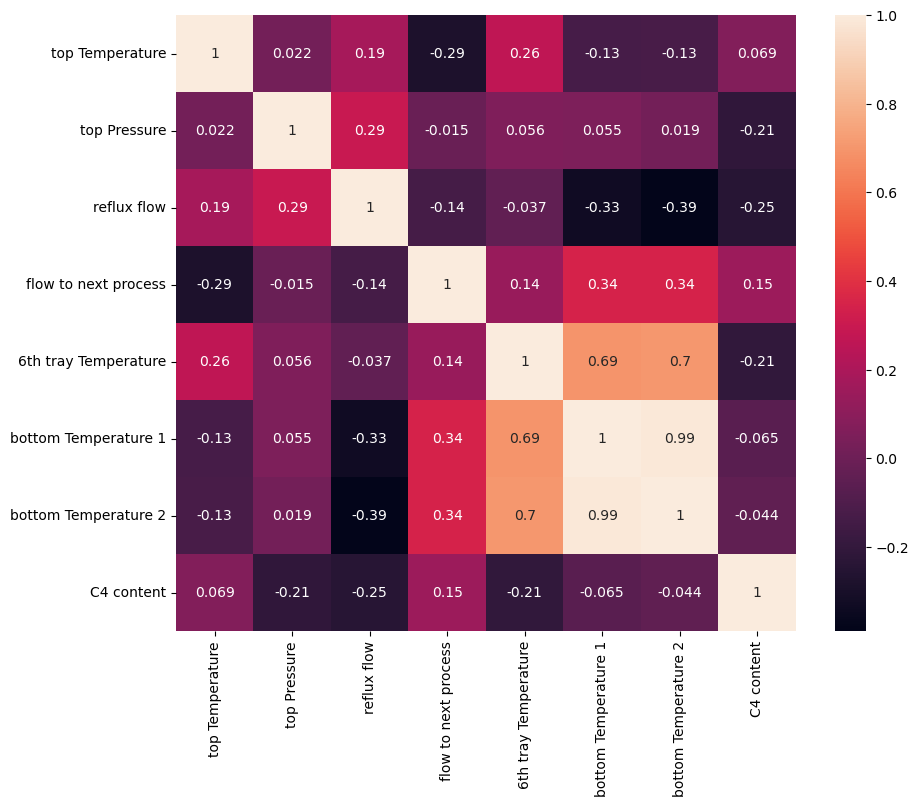

In [8]:
import seaborn as sns

plt.figure(figsize=(10,8))
corr = data_df.corr()
sns.heatmap(corr, annot=True)
plt.show()

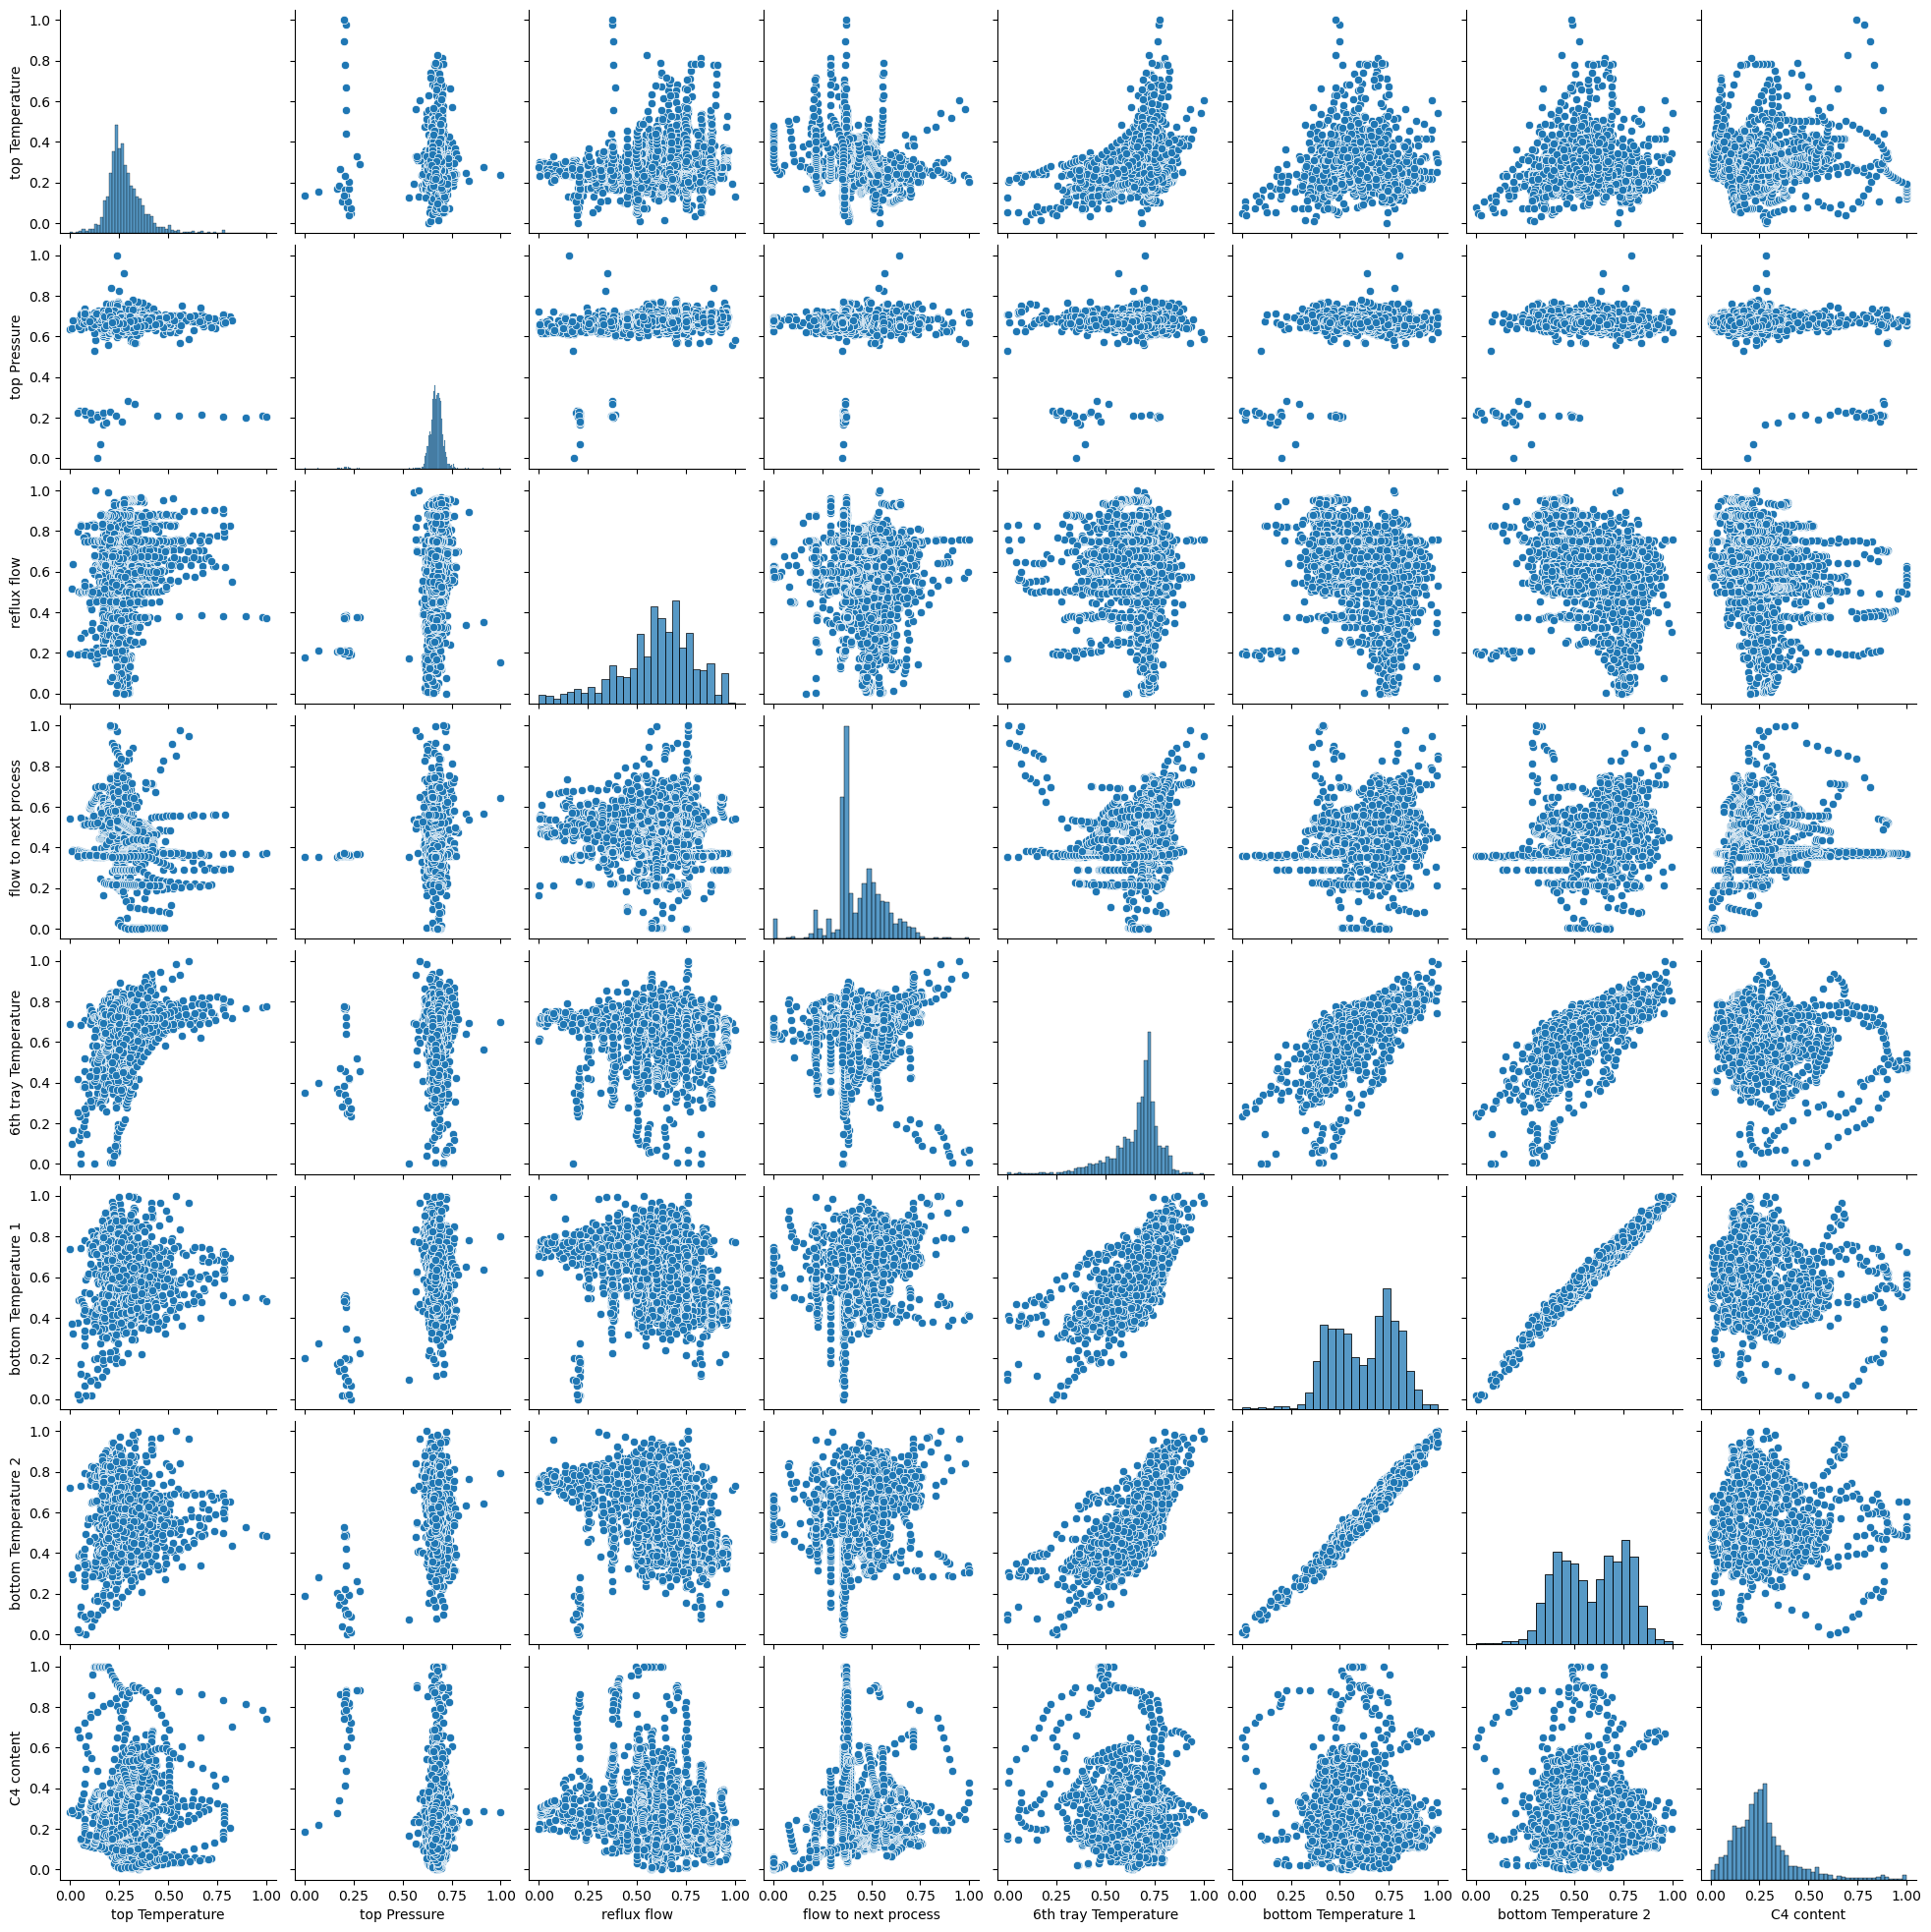

In [6]:
sns.pairplot(data_df)

In [7]:
# separate train and test data
from sklearn.model_selection import train_test_split
X = data[:,0:-1]
y = data[:,-1][:,np.newaxis]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 100)

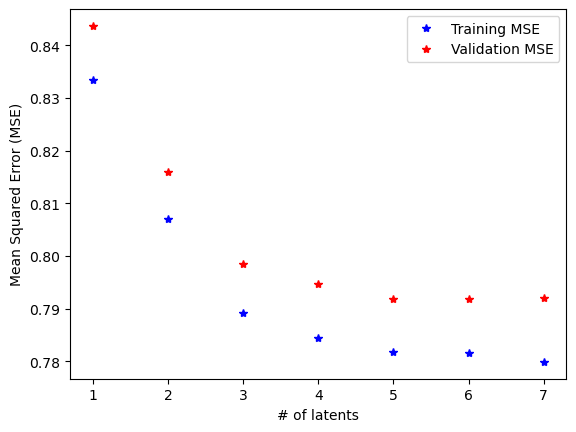

In [8]:
from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler()
X_train_normal = X_scaler.fit_transform(X_train)
X_test_normal = X_scaler.transform(X_test)

y_scaler = StandardScaler()
y_train_normal = y_scaler.fit_transform(y_train)
y_test_normal = y_scaler.transform(y_test)
# Finding # latents using kFold cross validation
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.cross_decomposition import PLSRegression

scaler = StandardScaler()

fit_MSE = []
validate_MSE = []
for n_comp in range(1,8):
    local_fit_MSE = []
    local_validate_MSE = []
    
    kfold = KFold(n_splits = 10, shuffle = True, random_state = 100)
    for fit_index, validate_index in kfold.split(y_train):
        X_fit_normal = scaler.fit_transform(X_train[fit_index])
        X_validate_normal = scaler.transform(X_train[validate_index])
        
        y_fit_normal = scaler.fit_transform(y_train[fit_index])
        y_validate_normal = scaler.transform(y_train[validate_index])
        
        pls = PLSRegression(n_components = n_comp)
        pls.fit(X_fit_normal, y_fit_normal)
        
        local_fit_MSE.append(mean_squared_error(y_fit_normal, pls.predict(X_fit_normal)))
        local_validate_MSE.append(mean_squared_error(y_validate_normal, 
                                                        pls.predict(X_validate_normal)))
    
    fit_MSE.append(np.mean(local_fit_MSE))
    validate_MSE.append(np.mean(local_validate_MSE))


# plot
plt.figure()
plt.plot(range(1,8), fit_MSE, 'b*', label = 'Training MSE')
plt.plot(range(1,8), validate_MSE, 'r*', label = 'Validation MSE')
plt.xticks(range(1,8))
plt.ylabel('Mean Squared Error (MSE)')
plt.xlabel('# of latents')
plt.legend()

In [10]:
# build PLS model
pls = PLSRegression(n_components = 5)
pls.fit(X_train_normal, y_train_normal)
# check training vs test accuracy
print('Accuracy over training data: ', pls.score(X_train_normal, y_train_normal))
print('Accuracy over test data: ', pls.score(X_test_normal, y_test_normal))

Accuracy over training data:  0.21790060542840162
Accuracy over test data:  0.1882053961720188


Text(0, 0.5, 'C4 content (prediction)')

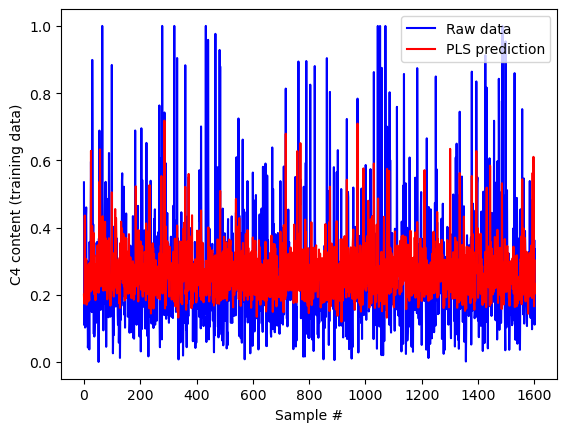

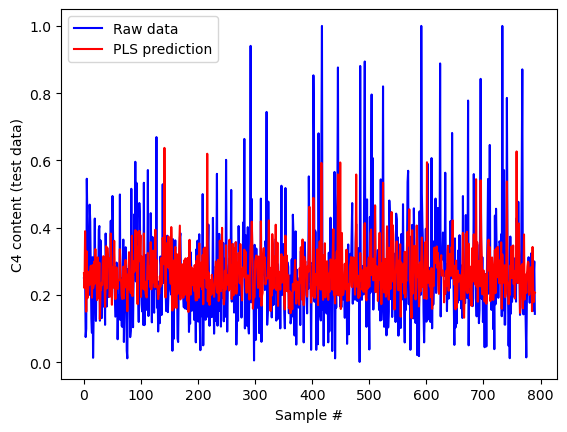

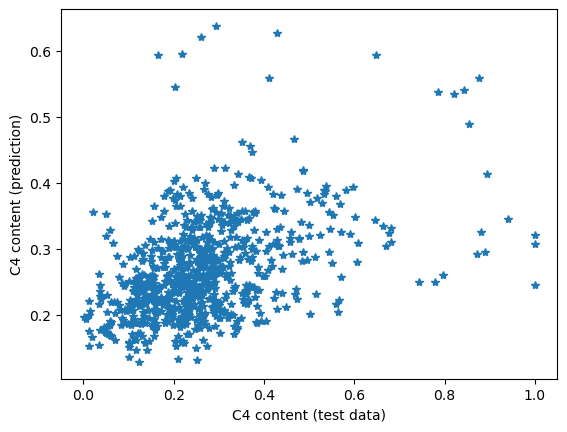

In [18]:
# plots of raw and predicted data
y_train_normal_predict = pls.predict(X_train_normal)
y_test_normal_predict = pls.predict(X_test_normal)

y_train_predict = y_scaler.inverse_transform(y_train_normal_predict)
y_test_predict = y_scaler.inverse_transform(y_test_normal_predict)


plt.figure()
plt.plot(y_train, 'b',  label = 'Raw data')
plt.plot(y_train_predict, 'r', label = 'PLS prediction')
plt.ylabel('C4 content (training data)')
plt.xlabel('Sample #')
plt.legend()


plt.figure()
plt.plot(y_test, 'b',  label = 'Raw data')
plt.plot(y_test_predict, 'r',  label = 'PLS prediction')
plt.ylabel('C4 content (test data)')
plt.xlabel('Sample #')
plt.legend()

plt.figure()
plt.plot(y_test, y_test_predict, '*')
plt.xlabel('C4 content (test data)')
plt.ylabel('C4 content (prediction)')

Text(0.5, 1.0, 'residual plot')

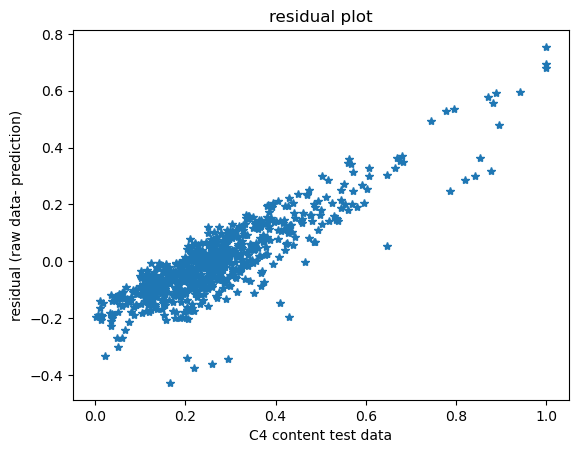

In [19]:
# residuals
plt.figure()
plt.plot(y_test, y_test-y_test_predict, '*')
plt.xlabel('C4 content test data')
plt.ylabel('residual (raw data- prediction)')
plt.title('residual plot')

In [20]:
# separate train and test data
from sklearn.model_selection import train_test_split
X = data[:,0:-1]
y = data[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 100)

In [21]:
# fit SVR model via grid-search
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

model = SVR(epsilon=0.05)
param_grid = [{'gamma': np.linspace(1,10,10), 'C': np.linspace(0.01,500,10)}]
gs = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=10, verbose=0)

gs.fit(X_train, y_train)
print('Optimal hyperparameter:', gs.best_params_)

Optimal hyperparameter: {'C': 55.56444444444444, 'gamma': 10.0}


In [22]:
# predict using the best model
y_train_predicted = gs.predict(X_train)
y_test_predicted = gs.predict(X_test)

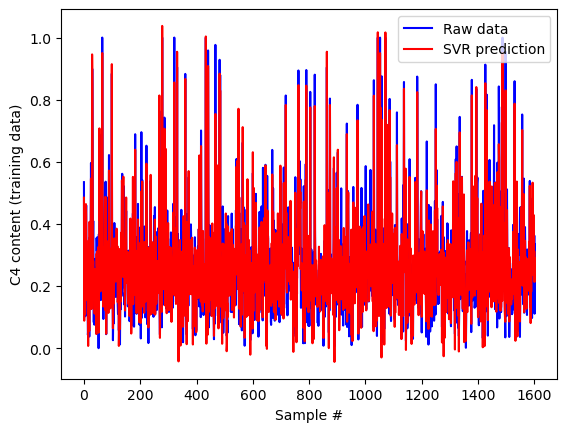

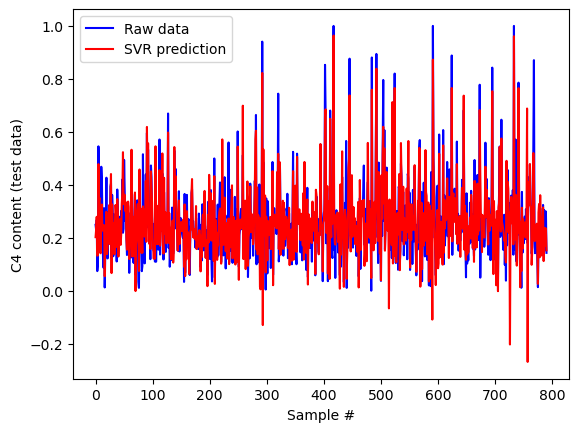

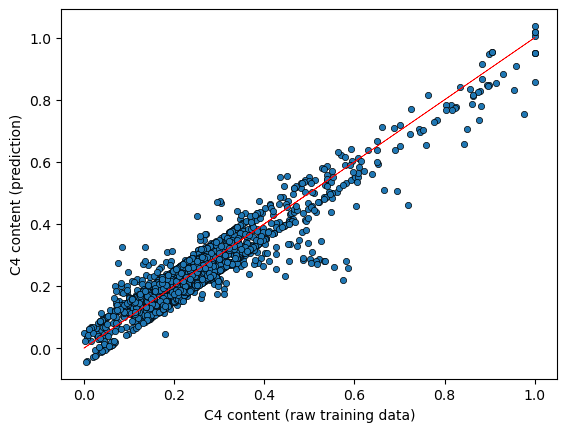

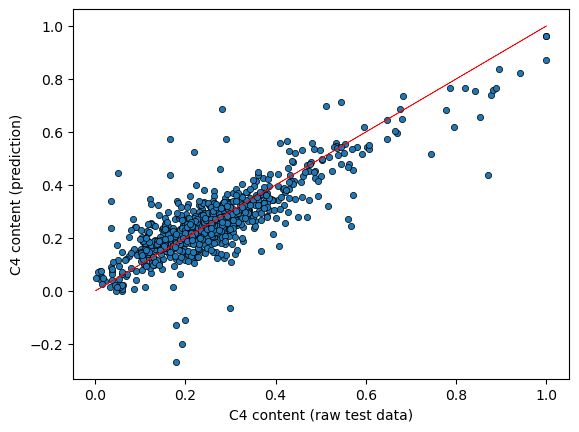

In [23]:
# plots of raw and predicted data
plt.figure()
plt.plot(y_train, 'b',  label = 'Raw data')
plt.plot(y_train_predicted, 'r', label = 'SVR prediction')
plt.ylabel('C4 content (training data)')
plt.xlabel('Sample #')
plt.legend()
plt.show()

plt.figure()
plt.plot(y_test, 'b',  label = 'Raw data')
plt.plot(y_test_predicted, 'r',  label = 'SVR prediction')
plt.ylabel('C4 content (test data)')
plt.xlabel('Sample #')
plt.legend()
plt.show()

plt.figure()
plt.plot(y_train, y_train_predicted, '.', markeredgecolor='k', markeredgewidth=0.5, ms=9)
plt.plot(y_train, y_train, '-r', linewidth=0.5)
plt.xlabel('C4 content (raw training data)')
plt.ylabel('C4 content (prediction)')
plt.show()

plt.figure()
plt.plot(y_test, y_test_predicted, '.', markeredgecolor='k', markeredgewidth=0.5, ms=9)
plt.plot(y_test, y_test, '-r', linewidth=0.5)
plt.xlabel('C4 content (raw test data)')
plt.ylabel('C4 content (prediction)')
plt.show()

In [24]:
# check training vs test accuracy
from sklearn.metrics import r2_score
print('Accuracy over training data: ', r2_score(y_train, y_train_predicted))
print('Accuracy over test data: ', r2_score(y_test, y_test_predicted))

Accuracy over training data:  0.8855757689727496
Accuracy over test data:  0.7049880989427286


In [25]:
# random number seed for result reproducibility 
from numpy.random import seed
import numpy as np
import matplotlib.pyplot as plt 
seed(1)
import tensorflow
tensorflow.random.set_seed(2)
#%% import packages
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [26]:
# read data
data = np.loadtxt('debutanizer_data.txt', skiprows=5)
# separate training, validation, and test data
from sklearn.model_selection import train_test_split
X = data[:,0:-1]
y = data[:,-1][:,np.newaxis]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 100)
X_est, X_val, y_est, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 100)

# define model
model = Sequential()
model.add(Dense(60, kernel_regularizer=regularizers.L1(0.0000001), activation='relu', kernel_initializer='he_normal', input_shape=(7,)))
model.add(Dense(30, kernel_regularizer=regularizers.L1(0.0000001), activation='relu', kernel_initializer='he_normal'))
model.add(Dense(30, kernel_regularizer=regularizers.L1(0.0000001), activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1, kernel_regularizer=regularizers.L1(0.0000001)))
# compile model
model.compile(loss='mse', optimizer=Adam(learning_rate=0.005))
# fit model
es = EarlyStopping(monitor='val_loss', patience=200)
history = model.fit(X_est, y_est, epochs=2000, batch_size=32, validation_data=(X_val, y_val), callbacks=es, verbose=0)

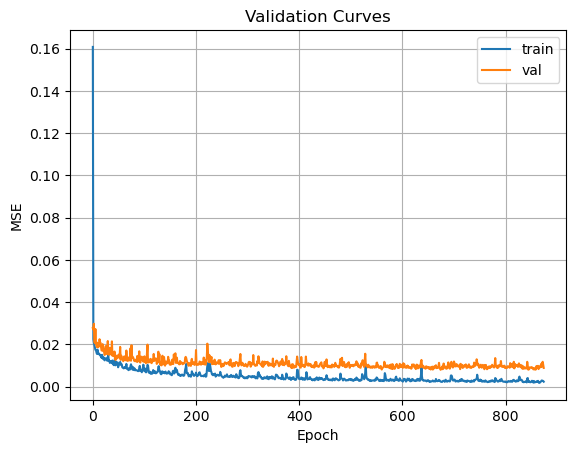

In [27]:
# plot validation curve
plt.figure()
plt.title('Validation Curves')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.grid()
plt.show()

In [28]:
# predict y
y_test_pred = model.predict(X_test)
y_val_pred = model.predict(X_val)
y_est_pred = model.predict(X_est)

38/38 [==============================] - 0s 618us/step


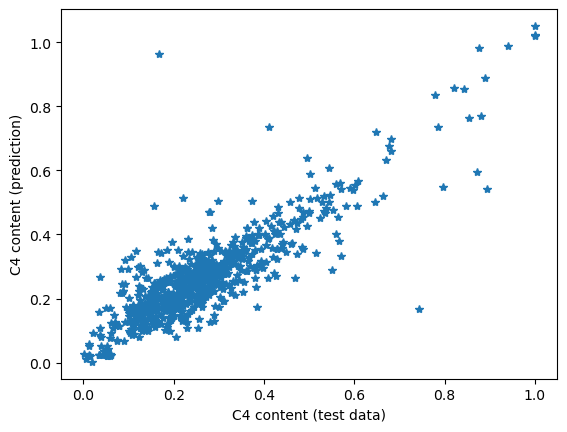

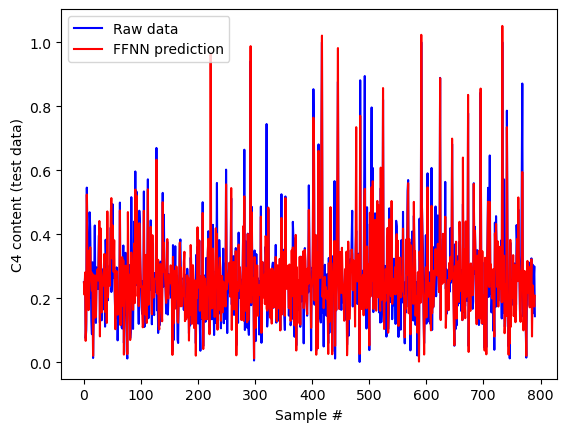

In [29]:
# plots of raw and predicted data
plt.figure()
plt.plot(y_test, y_test_pred, '*')
plt.xlabel('C4 content (test data)')
plt.ylabel('C4 content (prediction)')

plt.figure()
plt.plot(y_test, 'b', label='Raw data')
plt.plot(y_test_pred, 'r', label='FFNN prediction')
plt.ylabel('C4 content (test data)')
plt.xlabel('Sample #')
plt.legend()

Text(0.5, 1.0, 'residual plot')

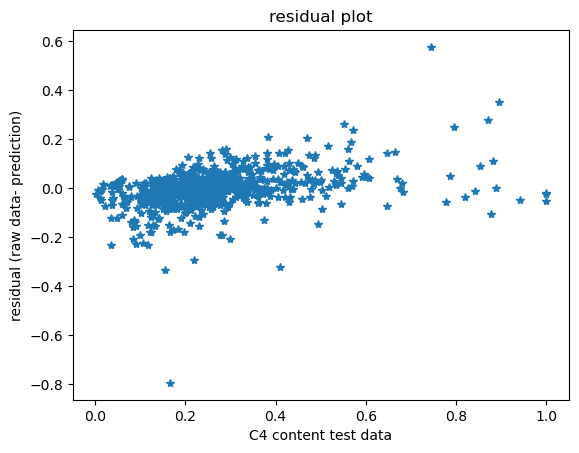

In [30]:
# residuals
plt.figure()
plt.plot(y_test, y_test-y_test_pred, '*')
plt.xlabel('C4 content test data')
plt.ylabel('residual (raw data- prediction)')
plt.title('residual plot')

In [31]:
# metrics
from sklearn.metrics import r2_score
print('R2 for test dataset:', r2_score(y_test, y_test_pred))
print('R2:', r2_score(y_val, y_val_pred))
print('R2:', r2_score(y_est, y_est_pred))

R2 for test dataset: 0.7348825144251296
R2: 0.6999906575040789
R2: 0.9347347002850666
